/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5416 - loss: 1.5665 - val_accuracy: 0.7515 - val_loss: 1.1597
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7671 - loss: 0.7759 - val_accuracy: 0.6986 - val_loss: 0.8161
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 0.5860 - val_accuracy: 0.8595 - val_loss: 0.5389
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9027 - loss: 0.4121 - val_accuracy: 0.9185 - val_loss: 0.3699
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.2996 - val_accuracy: 0.9898 - val_loss: 0.1881
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.2312 - val_accuracy: 0.9939 - val_loss: 0.1761
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.1856 - val_accuracy: 0.9980 - val_loss: 0.1311
Epoch 8/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.1646 - val_accuracy: 

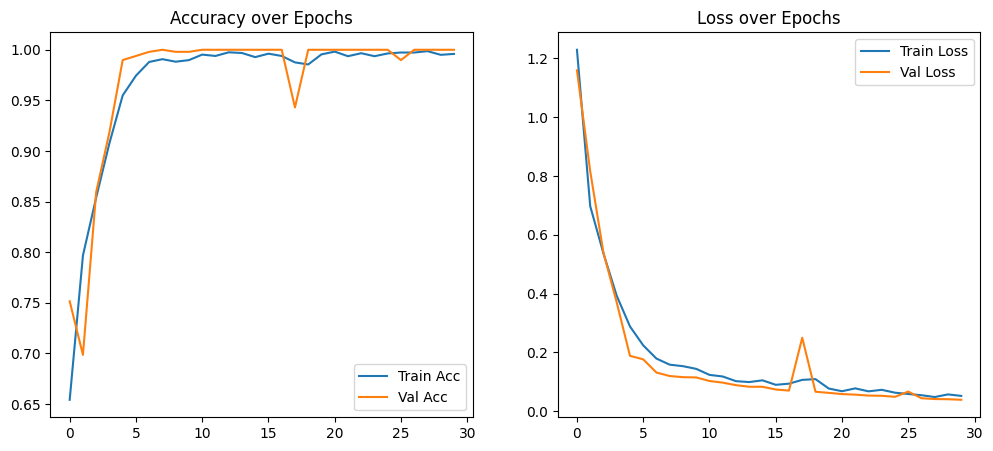

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("/kaggle/input/datasets-own/esp32_attack_data.csv")

# Drop unnecessary features
df = df.drop(columns=['Source IP', 'Destination IP', 'TCP Flags'])

# Drop missing values
df = df.dropna()

# Encode labels
le = LabelEncoder()
df['Attack Type'] = le.fit_transform(df['Attack Type'])
np.save("label_classes.npy", le.classes_)

# Define features and target
X = df.drop(columns=['Attack Type'])
y = df['Attack Type']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode target labels
y = to_categorical(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build an optimized model
model = Sequential([
    Dense(128, input_shape=(X.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implement K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,  # Increased epochs
    batch_size=32,
    verbose=1
)

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# Save model
model.save("esp32_attack_model_optimized.h5")
print("\n✅ Model saved as esp32_attack_model_optimized.h5")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Predictions saved to attack_predictions.csv

🎯 Model Accuracy on New Data: 99.98%

🔍 Classification Report:
                   precision    recall  f1-score   support

        DNS Query       1.00      1.00      1.00       100
     HTTP Request       1.00      1.00      1.00       500
Malformed Packets       1.00      1.00      1.00       500
           Normal       1.00      1.00      1.00      3511
        Port Scan       1.00      1.00      1.00      1005
        SYN Flood       1.00      1.00      1.00       500
        UDP Flood       1.00      1.00      1.00       500

         accuracy                           1.00      6616
        macro avg       1.00      1.00      1.00      6616
     weighted avg       1.00      1.00      1.00      6616



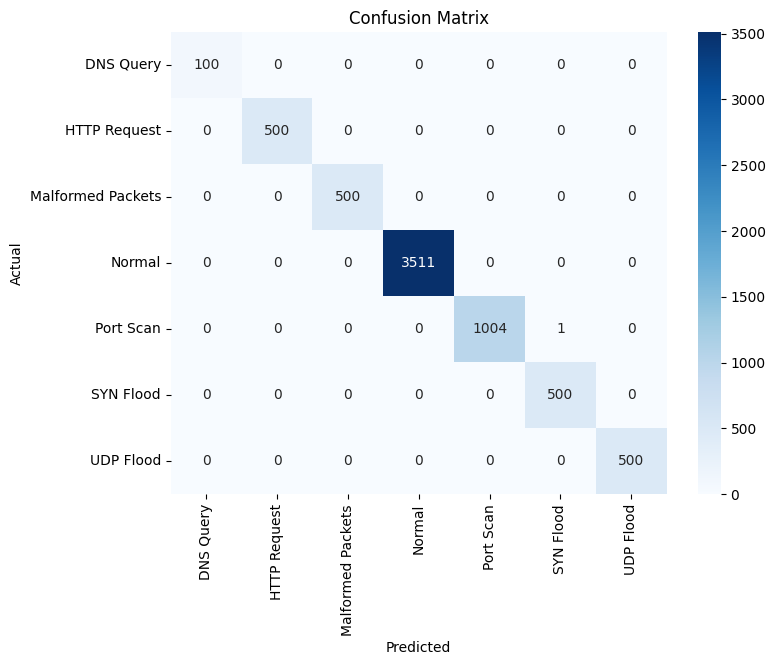

In [2]:
# 🚀 IoT Cyber Attack Detection - Model Testing on New Data (Kaggle Version)

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the trained model
model = tf.keras.models.load_model("/kaggle/working/esp32_attack_model_optimized.h5")

# Load new dataset
new_df = pd.read_csv("/kaggle/input/datasets-own/esp32_attack_data_test.csv")

# Drop high-cardinality or less useful features
new_df = new_df.drop(columns=['Source IP', 'Destination IP', 'TCP Flags'], errors='ignore')

# Handle missing values (same method as in training)
new_df = new_df.dropna()

# Extract ground truth labels (if available)
if 'Attack Type' in new_df.columns:
    true_labels = new_df['Attack Type']
    new_df = new_df.drop(columns=['Attack Type'])
else:
    true_labels = None

# Normalize features (use same scaler from training)
scaler = StandardScaler()
X_new = scaler.fit_transform(new_df)

# Make predictions
predictions = model.predict(X_new)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Load label encoder from training phase
le = LabelEncoder()
le.classes_ = np.load("/kaggle/working/label_classes.npy", allow_pickle=True)
predicted_attack_types = le.inverse_transform(predicted_labels)

# Save predictions to CSV
output_df = pd.DataFrame({"Predicted Attack Type": predicted_attack_types})
output_df.to_csv("attack_predictions.csv", index=False)

print("✅ Predictions saved to attack_predictions.csv")


# If ground truth labels exist, calculate accuracy
if true_labels is not None:
    true_labels_encoded = le.transform(true_labels)
    accuracy = accuracy_score(true_labels_encoded, predicted_labels)
    print(f"\n🎯 Model Accuracy on New Data: {accuracy * 100:.2f}%")

    # Display classification report
    print("\n🔍 Classification Report:")
    print(classification_report(true_labels_encoded, predicted_labels, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(true_labels_encoded, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [3]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("/kaggle/working/esp32_attack_model_optimized.h5")

# Convert to TFLite with float16 quantization (better for ESP32)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # Reduces model size & inference time

tflite_model = converter.convert()

# Save the converted model
tflite_model_path = "/kaggle/working/esp32_attack_model_optimized.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ Model converted and saved at {tflite_model_path}")


Saved artifact at '/tmp/tmp7od7i74f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140682325411792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325416720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325460592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325459536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325423056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325425344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325470096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325470976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325560128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325558368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140682325558192: TensorSp


✅ Random Forest Test Accuracy: 100.00%

                   precision    recall  f1-score   support

        DNS Query       1.00      1.00      1.00        20
     HTTP Request       1.00      1.00      1.00       100
Malformed Packets       1.00      1.00      1.00       100
           Normal       1.00      1.00      1.00       605
        Port Scan       1.00      1.00      1.00       201
        SYN Flood       1.00      1.00      1.00       100
        UDP Flood       1.00      1.00      1.00       100

         accuracy                           1.00      1226
        macro avg       1.00      1.00      1.00      1226
     weighted avg       1.00      1.00      1.00      1226



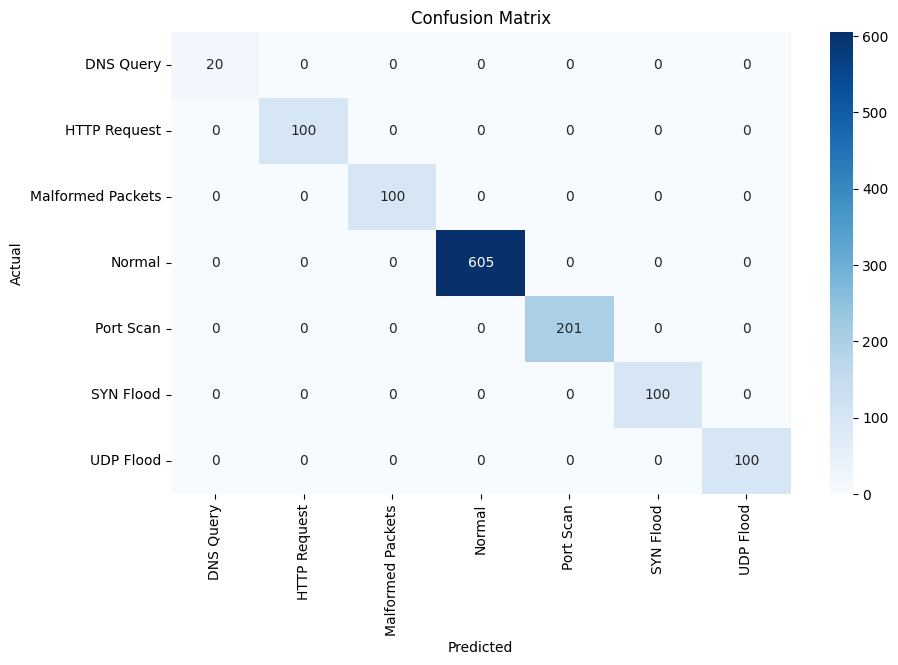


📊 5-Fold CV Accuracy: 100.00% ± 0.00%


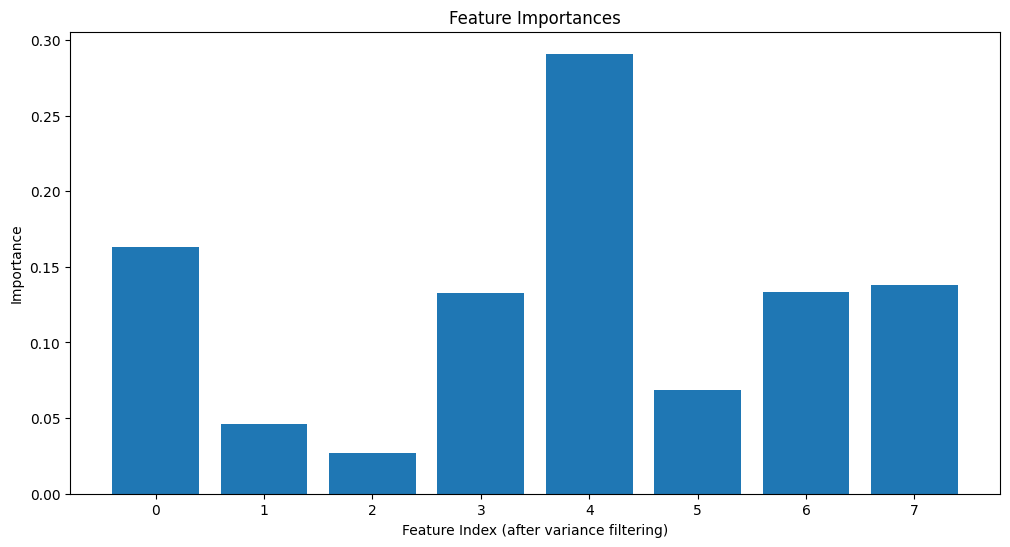


🧪 External Dataset Accuracy: 99.94%
                   precision    recall  f1-score   support

        DNS Query       1.00      1.00      1.00       100
     HTTP Request       1.00      1.00      1.00       500
Malformed Packets       1.00      1.00      1.00       500
           Normal       1.00      1.00      1.00      3511
        Port Scan       1.00      1.00      1.00      1005
        SYN Flood       1.00      0.99      1.00       500
        UDP Flood       1.00      1.00      1.00       500

         accuracy                           1.00      6616
        macro avg       1.00      1.00      1.00      6616
     weighted avg       1.00      1.00      1.00      6616



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold

# Load dataset
df = pd.read_csv("/kaggle/input/datasets-own/esp32_attack_data.csv")

# Drop unnecessary columns
df = df.drop(columns=['Source IP', 'Destination IP', 'TCP Flags'], errors='ignore')
df = df.dropna()

# Label encode the target
le = LabelEncoder()
df['Attack Type'] = le.fit_transform(df['Attack Type'])
np.save("label_classes.npy", le.classes_)

# Feature/target split
X = df.drop(columns=['Attack Type'])
y = df['Attack Type']

# Remove low-variance features (optional regularization)
selector = VarianceThreshold(threshold=0.01)
X = selector.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Anti-overfitting tuned Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,               # Fewer trees = less overfitting risk
    max_depth=15,                   # Limit tree depth
    min_samples_split=10,           # Require more samples to split
    min_samples_leaf=5,             # Don't allow too-specific leaves
    max_features='sqrt',            # Random subspace selection
    class_weight='balanced',        # Handle class imbalance
    random_state=42
)

rf_model.fit(X_train, y_train)

# Evaluation on test set
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Random Forest Test Accuracy: {acc * 100:.2f}%\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='accuracy')
print(f"\n📊 5-Fold CV Accuracy: {np.mean(cv_scores) * 100:.2f}% ± {np.std(cv_scores) * 100:.2f}%")

# 🔍 Feature Importance
importances = rf_model.feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances")
plt.xlabel("Feature Index (after variance filtering)")
plt.ylabel("Importance")
plt.show()

# Optional External Dataset Test
try:
    df_test = pd.read_csv("/kaggle/input/datasets-own/esp32_attack_data_test.csv")
    df_test = df_test.drop(columns=['Source IP', 'Destination IP', 'TCP Flags'], errors='ignore')
    df_test = df_test.dropna()

    X_test_ext = df_test.drop(columns=['Attack Type'])
    X_test_ext = selector.transform(X_test_ext)
    X_test_ext = scaler.transform(X_test_ext)

    y_test_ext = le.transform(df_test['Attack Type'])
    y_pred_ext = rf_model.predict(X_test_ext)
    acc_ext = accuracy_score(y_test_ext, y_pred_ext)

    print(f"\n🧪 External Dataset Accuracy: {acc_ext * 100:.2f}%")
    print(classification_report(y_test_ext, y_pred_ext, target_names=le.classes_))

except Exception as e:
    print(f"\n⚠️ Could not load/test external dataset: {e}")



✅ Test Accuracy: 100.00%
                   precision    recall  f1-score   support

        DNS Query       1.00      1.00      1.00        20
     HTTP Request       1.00      1.00      1.00       100
Malformed Packets       1.00      1.00      1.00       100
           Normal       1.00      1.00      1.00       605
        Port Scan       1.00      1.00      1.00       201
        SYN Flood       1.00      1.00      1.00       100
        UDP Flood       1.00      1.00      1.00       100

         accuracy                           1.00      1226
        macro avg       1.00      1.00      1.00      1226
     weighted avg       1.00      1.00      1.00      1226



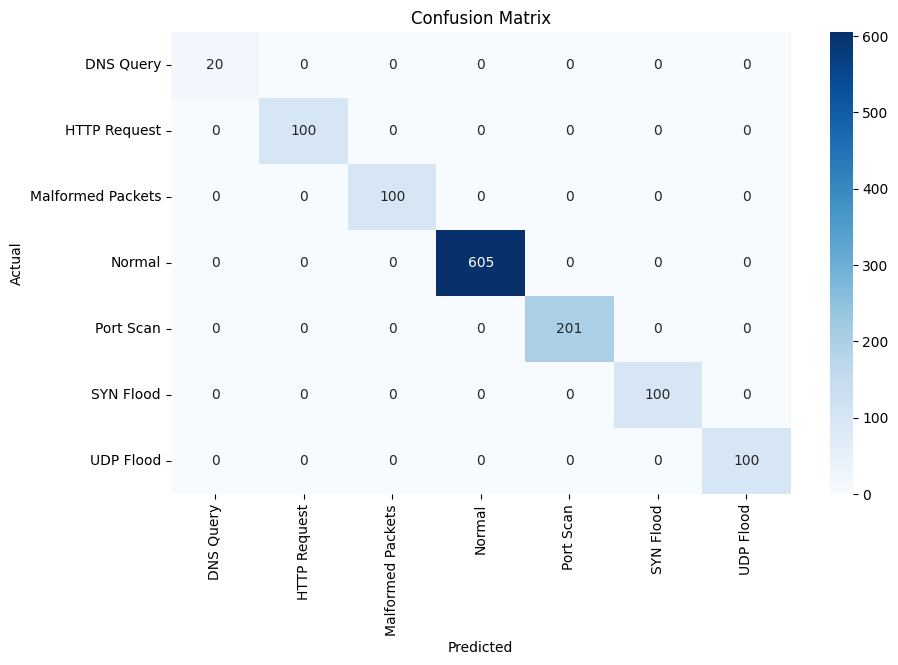

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


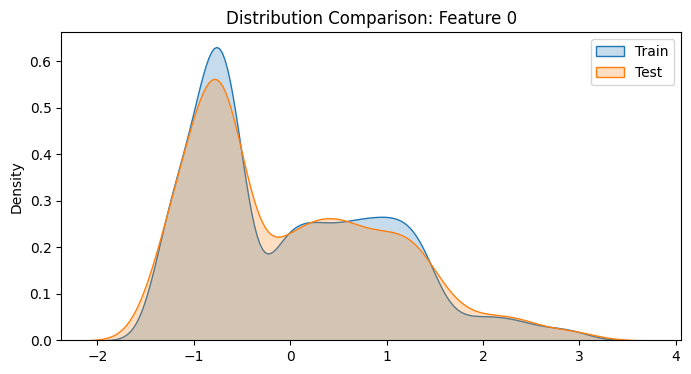

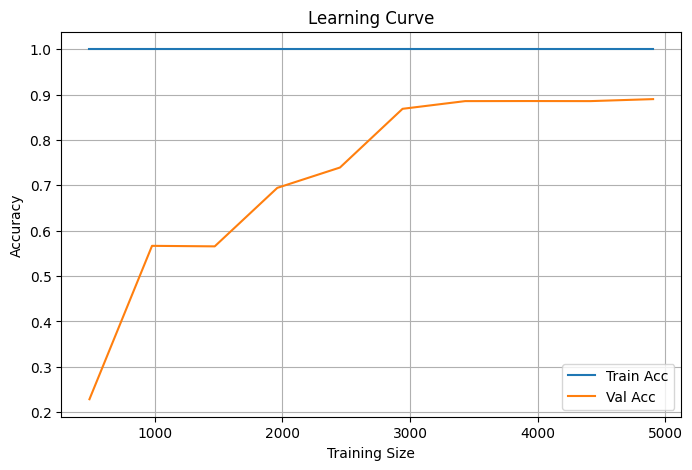


🌪 Accuracy with Slight Noise: 99.27%

📈 5-Fold CV Accuracy: 100.00% ± 0.00%

🧪 External Dataset Accuracy: 99.92%
                   precision    recall  f1-score   support

        DNS Query       1.00      1.00      1.00       100
     HTTP Request       1.00      1.00      1.00       500
Malformed Packets       1.00      1.00      1.00       500
           Normal       1.00      1.00      1.00      3511
        Port Scan       1.00      1.00      1.00      1005
        SYN Flood       1.00      0.99      0.99       500
        UDP Flood       1.00      1.00      1.00       500

         accuracy                           1.00      6616
        macro avg       1.00      1.00      1.00      6616
     weighted avg       1.00      1.00      1.00      6616



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve

# Load dataset
df = pd.read_csv("/kaggle/input/datasets-own/esp32_attack_data.csv")

# Drop unnecessary columns
df = df.drop(columns=['Source IP', 'Destination IP', 'TCP Flags'], errors='ignore')
df = df.dropna()

# Label encode the target
le = LabelEncoder()
df['Attack Type'] = le.fit_transform(df['Attack Type'])
np.save("label_classes.npy", le.classes_)

# Features and labels
X = df.drop(columns=['Attack Type'])
y = df['Attack Type']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Build a more regularized, shallow RF
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=5,
    class_weight='balanced', random_state=42
)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 🔁 Distribution Check
plt.figure(figsize=(8, 4))
sns.kdeplot(X_train[:, 0], label="Train", fill=True)
sns.kdeplot(X_test[:, 0], label="Test", fill=True)
plt.title("Distribution Comparison: Feature 0")
plt.legend()
plt.show()

# 📉 Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_scaled, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train Acc")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Val Acc")
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 🌪 Robustness Test (Noise Injection)
X_test_noisy = X_test + np.random.normal(0, 0.01, X_test.shape)
y_pred_noisy = rf_model.predict(X_test_noisy)
acc_noisy = accuracy_score(y_test, y_pred_noisy)
print(f"\n🌪 Accuracy with Slight Noise: {acc_noisy * 100:.2f}%")

# 📊 K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='accuracy')
print(f"\n📈 5-Fold CV Accuracy: {np.mean(cv_scores) * 100:.2f}% ± {np.std(cv_scores) * 100:.2f}%")

# 🧪 Optional External Dataset Testing
try:
    df_test = pd.read_csv("/kaggle/input/datasets-own/esp32_attack_data_test.csv")
    df_test = df_test.drop(columns=['Source IP', 'Destination IP', 'TCP Flags'], errors='ignore')
    df_test = df_test.dropna()
    
    y_test_ext = le.transform(df_test['Attack Type'])
    X_test_ext = scaler.transform(df_test.drop(columns=['Attack Type']))

    y_pred_ext = rf_model.predict(X_test_ext)
    acc_ext = accuracy_score(y_test_ext, y_pred_ext)

    print(f"\n🧪 External Dataset Accuracy: {acc_ext * 100:.2f}%")
    print(classification_report(y_test_ext, y_pred_ext, target_names=le.classes_))

except Exception as e:
    print(f"\n⚠️ Could not test on external dataset: {e}")
